In [1]:
import  os
import  numpy as np
import  numpy.random  as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

In [2]:
def calc_likelihood(data, mu, sigma, pi, K):
    likelihood = np.zeros((np.sum(n), 3))
    for k in range(K):
        likelihood[:, k] = [pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for d in data]
    return likelihood

def calc_prob_gmm(data, mu, sigma, pi, K):
    return [[pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for k in range(K)] for d in data]

def print_gmm_contour(data, mu, sigma, pi, K):
    # display predicted scores by the model as a contour plot
    max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
    max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
    X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu, sigma, pi, K)), axis=1)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, alpha=0.2, zorder=-100)
    
    plt.title('pdf contour of a GMM')

## 混合ガウス分布に従うデータの生成

check:  0 [ 0.2  0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775
check:  1 [ 1.2  0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.002775
check:  2 [ 2.   0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775


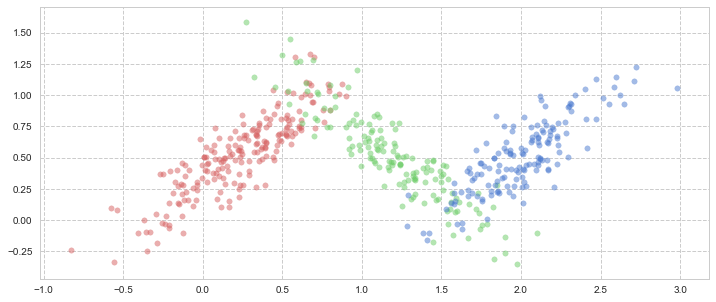

In [3]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

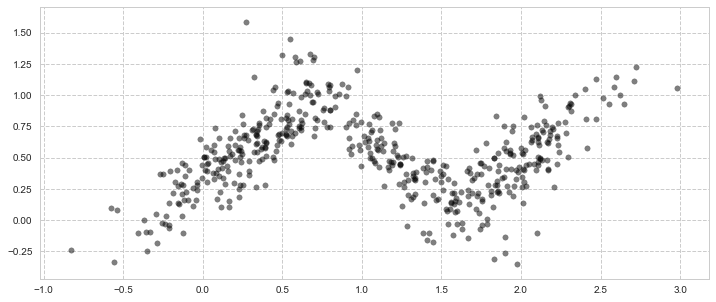

In [4]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c="black", alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

## EMアルゴリズム

### 1. パラメータの初期化

In [5]:
def initialize(data, K):
    # initialize pi
    pi = np.zeros(K)
    for k in range(K):
        if k == K-1:
            pi[k] = 1 - np.sum(pi)
        else:
            pi[k] = 1/K

    # initialize mu
    max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
    max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
    mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K)]

    # initialize sigma
    sigma = np.asanyarray([np.eye(D) for k in range(K)])

    # calculate likelihood
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    
    return mu, sigma, pi, K, likelihood

### 2. Eステップ

In [6]:
def E_step(likelihood):
    gamma = (likelihood.T/np.sum(likelihood, axis=1)).T
    
    return gamma

### 3. Mステップ

In [7]:
def M_step(data, mu, sigma, pi, K, N, D):
    # caluculate pi
    N_k = [np.sum(gamma[:,k]) for k in range(K)]
    pi = N_k / N

    # calculate mu
    tmp_mu = np.zeros((K, D))

    for k in range(K):
        for i in range(len(data)):
            tmp_mu[k] += gamma[i, k]*data[i]
        tmp_mu[k] = tmp_mu[k]/N_k[k]
    mu_prev = mu.copy()
    mu = tmp_mu.copy()
    
    # calculate sigma
    tmp_sigma = np.zeros((K, D, D))

    for k in range(K):
        tmp_sigma[k] = np.zeros((D, D))
        for i in range(N):
            tmp = np.asanyarray(data[i]-mu[k])[:,np.newaxis]
            tmp_sigma[k] += gamma[i, k]*np.dot(tmp, tmp.T)
        tmp_sigma[k] = tmp_sigma[k]/N_k[k]

    sigma = tmp_sigma.copy()
    
    return mu, sigma, pi, mu_prev

### 4. パラメータの評価

In [8]:
def convergence_checking(data, mu, sigma, pi, K, likelihood):
    # calculate likelihood
    prev_likelihood = likelihood
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    
    prev_sum_log_likelihood = np.sum(np.log(prev_likelihood))
    sum_log_likelihood = np.sum(np.log(likelihood))
    diff = prev_sum_log_likelihood - sum_log_likelihood
    
    return likelihood, diff

### 推定パラメータによるプロット

In [9]:
def visualize(data, mu, sigma, pi, mu_prev, K):
    # visualize
    plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=gamma[i], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8, head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')

    print_gmm_contour(data, mu, sigma, pi, K)

### EMアルゴリズムの動作確認

step: 33


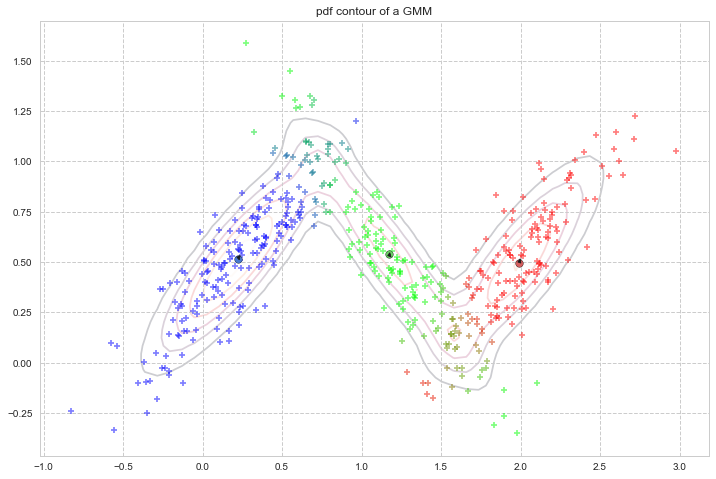

In [10]:
K = 3
mu, sigma, pi, K, likelihood = initialize(data, K)
likelihood
t = 0
# EMアルゴリズム
while(True):
    t += 1
    # Eステップ
    gamma = E_step(likelihood)
    # Mステップ
    mu, sigma, pi, mu_prev = M_step(data, mu, sigma, pi, K, N, D)
    # 収束の確認
    likelihood, diff = convergence_checking(data, mu, sigma, pi, K, likelihood)
    if(abs(diff)<0.0001):
        break

# 可視化
print("step:", t)
visualize(data, mu, sigma, pi, mu_prev, K)

### 真の混合ガウス分布

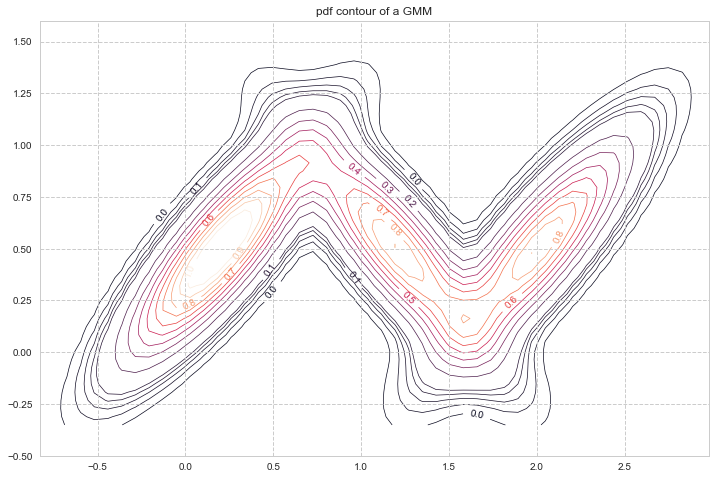

In [11]:
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])

mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])


plt.figure(figsize=(12, 8))
X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu_true, sigma_true, np.array(n)/N, K)), axis=1)
Z = Z.reshape(X.shape)
levels = np.r_[np.arange(0, 0.1, 0.02),np.arange(0.1, 1.1, 0.1)]
CS = plt.contour(X, Y, Z, alpha=1, zorder=-100, linewidths=0.7, levels=levels)#[0.2, 0.4, 0.8, 1.0])
CS.clabel(fmt='%1.1f', fontsize=10)
plt.ylim(-0.5, 1.6)
plt.title('pdf contour of a GMM')

step: 30


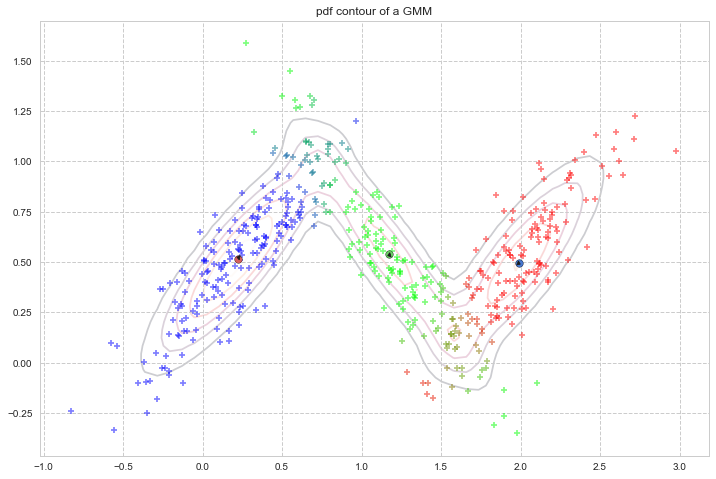

In [12]:
import os
home_dir = os.getcwd()
os.chdir("../src")
from em import EM
os.chdir(home_dir)

K = 3
prm = 0.0001
em = EM(data, K)
em.EM_Algorithm(data, prm)

# 可視化
print("step:", em.t)
visualize(data, em.mu, em.sigma, em.pi, em.mu_prev, em.K)